In [3]:
import os, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Đường dẫn dữ liệu
DATA_DIR = "mallorn-challenge/" 

# Đọc log files
print("Loading log files...")
try:
    train_log = pd.read_csv(f"{DATA_DIR}/train_log.csv")
    test_log  = pd.read_csv(f"{DATA_DIR}/test_log.csv")
    print("✅ Data Loaded Successfully.")
except FileNotFoundError:
    print("❌ Error: Files not found. Please check DATA_DIR path.")

Loading log files...
✅ Data Loaded Successfully.


In [4]:
def process_flux(df):
    """Tính các chỉ số Flux/Err bình phương"""
    eps = 1e-6
    # Thay thế 0 bằng NaN để tránh chia cho 0, sau đó fill lại
    flux_err_safe = df['Flux_err'].replace(0, np.nan)
    denom = np.power(flux_err_safe, 2) + eps
    flux_ratio_sq = np.power(df['Flux'], 2) / denom
    
    df_flux = pd.DataFrame({
        'flux_ratio_sq': flux_ratio_sq,
        'flux_by_flux_ratio_sq': df['Flux'] * flux_ratio_sq
    }, index=df.index)
    return pd.concat([df, df_flux], axis=1)

def build_features_from_lightcurves(df):
    """Trích xuất đặc trưng từ chuỗi thời gian"""
    # Sắp xếp để tính slope/time span đúng
    df = df.sort_values(["object_id", "Filter", "Time (MJD)"])

    # Feature trọng số
    df["w"] = 1.0 / (df["Flux_err"]**2 + 1e-9)
    df["flux_w"] = df["Flux"] * df["w"]
    
    # Gọi hàm phụ
    df = process_flux(df)
    
    # De-extinction (Khử bụi)
    df["Flux_Real"] = df["Flux"] * (10 ** ((df["EBV"].astype(float) + 1e-9) * 3.1 / 2.5))

    # 1. Aggregations cơ bản
    aggs = {
        "Flux": ["min", "max", "mean", "median", "std"],
        "Flux_Real": ['max', 'mean', 'min'],
        "Flux_err": ["mean"],
        "Time (MJD)": ["min", "max", "count"],
        "w": ["sum"],
        "flux_w": ["sum"],
        'flux_ratio_sq': ['max', 'mean', 'min', 'std'],
        'flux_by_flux_ratio_sq': ['max', 'mean', 'min', 'std']
    }

    # Groupby object & filter
    agg = df.groupby(["object_id", "Filter"]).agg(aggs)
    agg.columns = [f"{a}_{b}" for a, b in agg.columns]
    agg = agg.reset_index()

    # 2. Features vật lý nâng cao
    agg["flux_amp"] = agg["Flux_max"] - agg["Flux_min"]
    agg["flux_rel_amp"] = agg["flux_amp"] / (agg["Flux_mean"] + 1e-9)
    agg["time_span"] = agg["Time (MJD)_max"] - agg["Time (MJD)_min"]
    agg["flux_w_mean"] = agg["flux_w_sum"] / (agg["w_sum"] + 1e-9)
    
    # Slope (Độ dốc)
    agg["slope"] = (agg["Flux_max"] - agg["Flux_min"]) / (agg["time_span"] + 1e-9)
    
    # Shape stats
    agg["asymmetry"] = (agg["Flux_mean"] - agg["Flux_median"]) / (agg["Flux_std"] + 1e-9)
    agg["peak_sharpness"] = (agg["Flux_max"] - agg["Flux_mean"]) / (agg["Flux_std"] + 1e-9)
    
    # Color feature (Nếu có đủ band)
    if 'Flux_Real_max_u' in agg.columns and 'Flux_Real_max_g' in agg.columns:
        agg['color_u_g'] = agg['Flux_Real_max_u'] - agg['Flux_Real_max_g']
    else:
        agg['color_u_g'] = 0 # Fill 0 thay vì NaN để an toàn

    # Dọn dẹp cột trung gian
    agg.drop(columns=["flux_w_sum", "w_sum"], inplace=True, errors='ignore')

    # 3. Pivot (Chuyển Filter thành cột)
    agg["has_filter"] = 1
    filt = agg.pivot(index="object_id", columns="Filter", values="has_filter").fillna(0)
    filt.columns = [f"has_{c}" for c in filt.columns]

    numeric_cols = [c for c in agg.columns if c not in ["object_id", "Filter", "has_filter"]]
    wide = agg.pivot(index="object_id", columns="Filter", values=numeric_cols)
    
    # Làm phẳng tên cột (Flatten MultiIndex columns)
    wide.columns = [f"{c[0]}_{c[1]}" for c in wide.columns]
    wide = wide.reset_index().fillna(0)

    # Merge lại với thông tin filter presence
    return wide.merge(filt.reset_index(), on="object_id", how="left")

In [5]:
def load_splits(split_ids, mode="train"):
    all_feats = []
    meta = train_log if mode == "train" else test_log
    
    # Dùng tqdm để hiện thanh tiến trình cho đẹp
    for i in tqdm(split_ids, desc=f"Loading {mode} splits"):
        fname = f"{DATA_DIR}/split_{i:02d}/{mode}_full_lightcurves.csv"
        if os.path.exists(fname):
            df = pd.read_csv(fname)
            # Merge Metadata (Z, EBV) trước khi tính feature
            merge_cols = [c for c in ["object_id", "EBV", "Z"] if c in meta.columns]
            df = df.merge(meta[merge_cols], on="object_id", how="left")
            
            # Tính features
            feats = build_features_from_lightcurves(df)
            all_feats.append(feats)
            
            # Giải phóng RAM
            del df
            gc.collect()
            
    if not all_feats:
        return None
        
    full = pd.concat(all_feats, ignore_index=True)
    # Groupby lần cuối để chắc chắn không trùng lặp object_id
    return full.groupby("object_id", as_index=False).mean()

print("🚀 Processing TRAIN data...")
# Load 20 splits (hoặc chỉnh range nếu muốn test nhanh)
train_feats = load_splits(range(1, 21), mode="train")

# Merge Target và thông tin Z_err
train = train_feats.merge(
    train_log[["object_id", "Z", "Z_err", "EBV", "target"]],
    on="object_id", how="left"
).fillna(0)

# Tạo thêm feature tương tác với Redshift (Z)
for c in train.columns:
    if "flux_w_mean" in c:
        train[c + "_x_Z"] = train[c] * train["Z"]

# --- QUAN TRỌNG: Lưu danh sách cột để dùng cho Test ---
feature_cols = [c for c in train.columns if c not in ["object_id", "target"]]

# Chuyển sang NumPy Array để tránh lỗi .iloc trong KFold
X = train[feature_cols].values
y = train["target"].values

print(f"✅ Train shape: {train.shape}")
print(f"✅ Features count: {len(feature_cols)}")

🚀 Processing TRAIN data...


Loading train splits: 100%|██████████| 20/20 [00:02<00:00,  7.18it/s]

✅ Train shape: (3043, 185)
✅ Features count: 183


In [6]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Mảng lưu kết quả Out-of-Fold
oof_preds = np.zeros(X.shape[0])

# List lưu models
models_lgb = []
models_xgb = []
models_cat = []

# Tính scale_pos_weight tự động
pos = (y == 1).sum()
neg = (y == 0).sum()
scale_pos_weight = neg / (pos + 1)
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Tham số Models
params_lgb = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.03,
    "num_leaves": 96,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "scale_pos_weight": scale_pos_weight,
    "verbosity": -1,
    "seed": 42
}

params_xgb = {
    "max_depth": 7,
    "eta": 0.03,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "scale_pos_weight": scale_pos_weight,
    "tree_method": "hist",
    "seed": 42
}

print("\n🚀 Start 3-model Ensemble Training...")

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== FOLD {fold+1}/{N_FOLDS} ===")

    # Dùng numpy indexing (tránh lỗi iloc)
    Xtr, ytr = X[tr_idx], y[tr_idx]
    Xva, yva = X[va_idx], y[va_idx]

    # --- 1. LightGBM (Native API) ---
    dtr_lgb = lgb.Dataset(Xtr, label=ytr, feature_name=feature_cols)
    dva_lgb = lgb.Dataset(Xva, label=yva, feature_name=feature_cols)
    
    m_lgb = lgb.train(
        params_lgb, 
        dtr_lgb, 
        num_boost_round=1000,
        valid_sets=[dtr_lgb, dva_lgb],
        callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(0)] # Tắt log cho gọn
    )
    models_lgb.append(m_lgb)
    pred_lgb = m_lgb.predict(Xva)

    # --- 2. XGBoost (Native API) ---
    dtr_xgb = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_cols)
    dva_xgb = xgb.DMatrix(Xva, label=yva, feature_names=feature_cols)
    
    m_xgb = xgb.train(
        params_xgb, 
        dtr_xgb, 
        num_boost_round=1000,
        evals=[(dva_xgb, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    models_xgb.append(m_xgb)
    pred_xgb = m_xgb.predict(dva_xgb)

    # --- 3. CatBoost ---
    m_cat = CatBoostClassifier(
        depth=8,
        learning_rate=0.03,
        iterations=1000,
        loss_function="Logloss",
        eval_metric="Logloss",
        random_seed=42,
        verbose=False,
        allow_writing_files=False
    )
    m_cat.fit(Xtr, ytr, eval_set=(Xva, yva), early_stopping_rounds=50)
    models_cat.append(m_cat)
    pred_cat = m_cat.predict_proba(Xva)[:, 1]

    # --- Ensemble Averaging ---
    # Bạn có thể chỉnh trọng số ở đây nếu muốn (ví dụ: 0.4*LGB + 0.3*XGB + 0.3*CAT)
    oof_preds[va_idx] = (pred_lgb + pred_xgb + pred_cat) / 3
    
    # Check F1 sơ bộ tại ngưỡng 0.5
    f1_fold = f1_score(yva, (oof_preds[va_idx] >= 0.5).astype(int))
    print(f"Fold {fold+1} OOF F1 (thr=0.5): {f1_fold:.4f}")

print("✅ Training Completed.")

Calculated scale_pos_weight: 19.43

🚀 Start 3-model Ensemble Training...

=== FOLD 1/5 ===
Fold 1 OOF F1 (thr=0.5): 0.2222

=== FOLD 2/5 ===
Fold 2 OOF F1 (thr=0.5): 0.0541

=== FOLD 3/5 ===
Fold 3 OOF F1 (thr=0.5): 0.2857

=== FOLD 4/5 ===
Fold 4 OOF F1 (thr=0.5): 0.1714

=== FOLD 5/5 ===
Fold 5 OOF F1 (thr=0.5): 0.0667
✅ Training Completed.



🏆 Best OOF Threshold = 0.1337
🏆 Best OOF F1 Score  = 0.4082


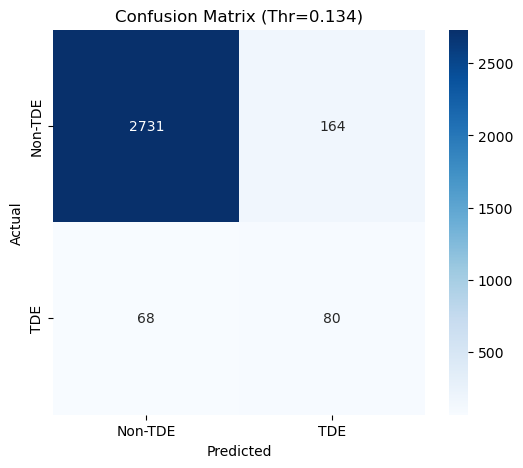

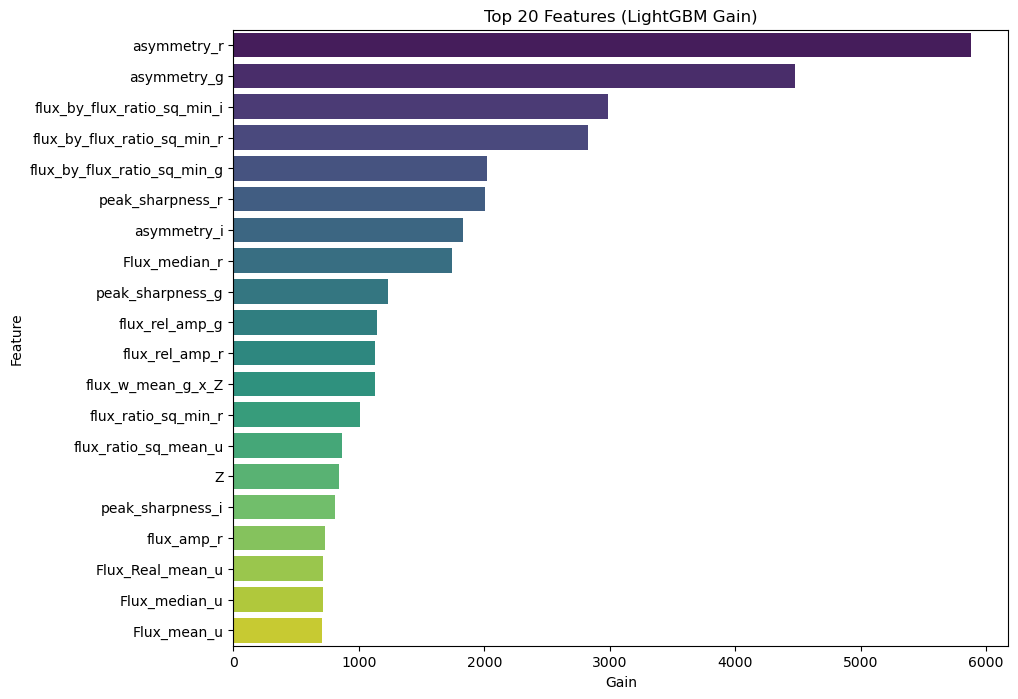

In [8]:
# --- 1. TÌM NGƯỠNG TỐI ƯU (Threshold Tuning) ---
best_thr = 0
best_f1 = 0

# Quét ngưỡng từ 0.05 đến 0.50
thresholds = np.linspace(0.05, 0.50, 200)
for t in thresholds:
    current_f1 = f1_score(y, (oof_preds >= t).astype(int))
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thr = t

print(f"\n🏆 Best OOF Threshold = {best_thr:.4f}")
print(f"🏆 Best OOF F1 Score  = {best_f1:.4f}")

# --- 2. CONFUSION MATRIX ---
final_preds = (oof_preds >= best_thr).astype(int)
cm = confusion_matrix(y, final_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
plt.title(f'Confusion Matrix (Thr={best_thr:.3f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- 3. ROBUST FEATURE IMPORTANCE (LightGBM) ---
# Hàm này xử lý an toàn việc lấy tên feature từ Native API
def plot_lgb_importances(models, feature_names):
    imp_dfs = []
    for model in models:
        # Native API dùng feature_importance() và feature_name()
        imps = model.feature_importance(importance_type='gain')
        names = model.feature_name()
        
        imp_dfs.append(pd.DataFrame({'Feature': names, 'Gain': imps}))
    
    # Gộp và tính trung bình
    if not imp_dfs: return
    
    df_imp = pd.concat(imp_dfs).groupby('Feature')['Gain'].mean().reset_index()
    df_imp = df_imp.sort_values('Gain', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Gain', y='Feature', data=df_imp, palette='viridis')
    plt.title('Top 20 Features (LightGBM Gain)')
    plt.show()

plot_lgb_importances(models_lgb, feature_cols)

In [9]:
print("🚀 Processing TEST data...")
test_feats = load_splits(range(1, 21), mode="test")

# Merge Metadata
test = test_feats.merge(
    test_log[["object_id", "Z", "Z_err", "EBV"]],
    on="object_id", how="left"
).fillna(0)

# Tạo feature tương tác Z (giống hệt train)
for c in test.columns:
    if "flux_w_mean" in c:
        test[c + "_x_Z"] = test[c] * test["Z"]

# --- QUAN TRỌNG: Đồng bộ cột (Align Columns) ---
# 1. Thêm cột thiếu (nếu có)
for col in feature_cols:
    if col not in test.columns:
        test[col] = 0

# 2. Chỉ giữ lại các cột đã dùng để train và đúng thứ tự
X_test = test[feature_cols].values

# Chuẩn bị DMatrix cho XGBoost
dtest = xgb.DMatrix(X_test, feature_names=feature_cols)

print(f"✅ Test shape aligned: {X_test.shape}")

# --- PREDICTION ---
sub_preds = np.zeros(X_test.shape[0])

for i in range(N_FOLDS):
    # Predict từng model
    p_lgb = models_lgb[i].predict(X_test)
    p_xgb = models_xgb[i].predict(dtest)
    p_cat = models_cat[i].predict_proba(X_test)[:, 1]
    
    # Ensemble Average
    sub_preds += (p_lgb + p_xgb + p_cat) / 3

sub_preds /= N_FOLDS

# --- SAVE SUBMISSION ---
# Lưu nhiều file với các ngưỡng lân cận để an toàn
threshold_list = [best_thr, best_thr - 0.02, best_thr + 0.02]

print("\n💾 Saving submissions...")
for thr in threshold_list:
    pred_binary = (sub_preds >= thr).astype(int)
    
    sub_df = pd.DataFrame({
        "object_id": test["object_id"],
        "prediction": pred_binary,
        "probability": sub_preds # Lưu thêm xác suất để debug nếu cần
    })
    
    fname = f"submission_ensemble_thr_{thr:.3f}.csv"
    sub_df[["object_id", "prediction"]].to_csv(fname, index=False)
    print(f"  -> Saved {fname} | Positive preds: {pred_binary.sum()}")

print("Done.")

🚀 Processing TEST data...


Loading test splits: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


✅ Test shape aligned: (7135, 183)

💾 Saving submissions...
  -> Saved submission_ensemble_thr_0.134.csv | Positive preds: 575
  -> Saved submission_ensemble_thr_0.114.csv | Positive preds: 663
  -> Saved submission_ensemble_thr_0.154.csv | Positive preds: 513
Done.


In [10]:
import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Đảm bảo X là DataFrame và y là Array để tránh lỗi .iloc
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, columns=feature_cols)
# y đã là array

print("✅ Đã nạp thư viện và dữ liệu.")

✅ Đã nạp thư viện và dữ liệu.


In [11]:
def objective_lgb(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        
        # Tuning Space
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_val, y_val = X.iloc[val_idx], y[val_idx]

        # Fill 0 & SMOTE
        X_train_filled = X_train.fillna(0)
        minority_count = int((y_train == 1).sum())
        k_neighbors = max(1, min(5, minority_count - 1))
        
        if k_neighbors > 0:
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_train_res, y_train_res = smote.fit_resample(X_train_filled, y_train)
        else:
            X_train_res, y_train_res = X_train_filled, y_train

        # Train
        model = lgb.LGBMClassifier(**param)
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        model.fit(X_train_res, y_train_res, 
                  eval_set=[(X_val.fillna(0), y_val)], 
                  callbacks=callbacks)

        # Eval
        probs = model.predict_proba(X_val.fillna(0))[:, 1]
        prec, rec, thr = precision_recall_curve(y_val, probs)
        f1s = 2 * prec * rec / (prec + rec + 1e-9)
        f1_scores.append(np.nanmax(f1s))

    return np.mean(f1_scores)

In [17]:
def objective_xgb(trial):
    # 1. Định nghĩa tham số (Đưa early_stopping_rounds vào đây)
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist', 
        'random_state': 42,
        'n_jobs': -1,
        
        # --- QUAN TRỌNG: Khai báo early_stopping_rounds ngay tại đây ---
        'early_stopping_rounds': 50,
        
        # Tuning Space
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # Dùng tên chuẩn reg_alpha/reg_lambda thay vì alpha/lambda để tránh cảnh báo
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_val, y_val = X.iloc[val_idx], y[val_idx]

        # FillNA & SMOTE
        X_train_filled = X_train.fillna(0)
        # Logic SMOTE thông minh của bạn
        minority_count = int((y_train == 1).sum())
        k_neighbors = max(1, min(5, minority_count - 1))
        
        if k_neighbors > 0:
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_train_res, y_train_res = smote.fit_resample(X_train_filled, y_train)
        else:
            X_train_res, y_train_res = X_train_filled, y_train

        # Khởi tạo model với params (đã bao gồm early_stopping_rounds)
        model = xgb.XGBClassifier(**params)
        
        # --- SỬA LỖI TẠI ĐÂY: Xóa early_stopping_rounds khỏi .fit() ---
        # Chỉ để lại eval_set và verbose
        model.fit(X_train_res, y_train_res, 
                  eval_set=[(X_val.fillna(0), y_val)], 
                  verbose=False)

        # Eval
        probs = model.predict_proba(X_val.fillna(0))[:, 1]
        prec, rec, thr = precision_recall_curve(y_val, probs)
        f1s = 2 * prec * rec / (prec + rec + 1e-9)
        f1_scores.append(np.nanmax(f1s))

    return np.mean(f1_scores)

In [13]:
def objective_cat(trial):
    param = {
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',
        'random_seed': 42,
        'verbose': 0,
        'allow_writing_files': False,
        
        # Tuning Space
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_val, y_val = X.iloc[val_idx], y[val_idx]

        # SMOTE (CatBoost xử lý tốt imbalanced nhưng SMOTE vẫn có thể giúp)
        X_train_filled = X_train.fillna(0)
        minority_count = int((y_train == 1).sum())
        k_neighbors = max(1, min(5, minority_count - 1))
        
        if k_neighbors > 0:
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_train_res, y_train_res = smote.fit_resample(X_train_filled, y_train)
        else:
            X_train_res, y_train_res = X_train_filled, y_train

        # Train
        model = CatBoostClassifier(**param)
        model.fit(X_train_res, y_train_res, 
                  eval_set=(X_val.fillna(0), y_val), 
                  early_stopping_rounds=50)

        # Eval
        probs = model.predict_proba(X_val.fillna(0))[:, 1]
        prec, rec, thr = precision_recall_curve(y_val, probs)
        f1s = 2 * prec * rec / (prec + rec + 1e-9)
        f1_scores.append(np.nanmax(f1s))

    return np.mean(f1_scores)

In [15]:
# 1. Tune LightGBM
print("🔍 Tuning LightGBM...")
study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=30) # Tăng n_trials nếu có thời gian
best_params_lgb = study_lgb.best_params
# Thêm các tham số cố định
best_params_lgb.update({'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 42, 'n_jobs': -1})


print("✅ Tuning hoàn tất.")

[I 2025-12-13 00:10:57,810] A new study created in memory with name: no-name-cbe96f1a-8435-480b-b385-89c4a919844d


🔍 Tuning LightGBM...


[I 2025-12-13 00:11:04,712] Trial 0 finished with value: 0.4308910449715958 and parameters: {'learning_rate': 0.019906996673933378, 'n_estimators': 1927, 'num_leaves': 225, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.4308910449715958.
[I 2025-12-13 00:11:08,525] Trial 1 finished with value: 0.41407909891039063 and parameters: {'learning_rate': 0.06813099824138592, 'n_estimators': 530, 'num_leaves': 292, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.4308910449715958.
[I 2025-12-13 00:11:12,565] Trial 2 finished with value: 0.4098767721872198 and parameters: {'learning_rate': 0.02460208061014162, 'n_estimators': 937, 'num_leaves': 191, 'max_depth': 4, '

✅ Tuning hoàn tất.


In [18]:
print("🔍 Tuning XGBoost (Fixed)...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=30) 

# Lấy kết quả
best_params_xgb = study_xgb.best_params
# Cập nhật các tham số cố định để dùng cho bước sau
best_params_xgb.update({
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss', 
    'tree_method': 'hist', 
    'random_state': 42, 
    'n_jobs': -1,
    'early_stopping_rounds': 50 # Đừng quên thêm cái này vào best_params cuối cùng
})

[I 2025-12-13 00:15:56,884] A new study created in memory with name: no-name-bd7ffa60-450b-48a9-b6ff-1a832dfb6d2d


🔍 Tuning XGBoost (Fixed)...


[I 2025-12-13 00:16:19,769] Trial 0 finished with value: 0.4443760679073809 and parameters: {'learning_rate': 0.019906996673933378, 'n_estimators': 1927, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.4443760679073809.
[I 2025-12-13 00:16:32,187] Trial 1 finished with value: 0.4052087370883733 and parameters: {'learning_rate': 0.045918988705873284, 'n_estimators': 1562, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.4443760679073809.
[I 2025-12-13 00:16:59,092] Trial 2 finished with value: 0.4291839612532399 and parameters: {'learning_rate': 0.015359756451337138, 'n_estimators': 1287, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.805926447361189

In [19]:


# 3. Tune CatBoost
print("🔍 Tuning CatBoost...")
study_cat = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_cat.optimize(objective_cat, n_trials=30)
best_params_cat = study_cat.best_params
best_params_cat.update({'loss_function': 'Logloss', 'eval_metric': 'Logloss', 'random_seed': 42, 'verbose': 0, 'allow_writing_files': False})


[I 2025-12-13 00:36:54,204] A new study created in memory with name: no-name-ff9f0f62-c772-4923-a50a-d27db648e25e


🔍 Tuning CatBoost...


[I 2025-12-13 00:37:36,060] Trial 0 finished with value: 0.4019565523864742 and parameters: {'iterations': 1062, 'learning_rate': 0.1667521176194013, 'depth': 9, 'l2_leaf_reg': 0.0024430162614261413, 'subsample': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014}. Best is trial 0 with value: 0.4019565523864742.
[I 2025-12-13 00:38:25,022] Trial 1 finished with value: 0.42744119685349746 and parameters: {'iterations': 587, 'learning_rate': 0.12207764786954153, 'depth': 8, 'l2_leaf_reg': 0.023585940584142682, 'subsample': 0.5102922471479012, 'colsample_bylevel': 0.9849549260809971}. Best is trial 1 with value: 0.42744119685349746.
[I 2025-12-13 00:39:20,957] Trial 2 finished with value: 0.4190819453890434 and parameters: {'iterations': 1749, 'learning_rate': 0.010943342660062645, 'depth': 5, 'l2_leaf_reg': 4.4734294104626844e-07, 'subsample': 0.6521211214797689, 'colsample_bylevel': 0.762378215816119}. Best is trial 1 with value: 0.42744119685349746.
[I 2025-12-13 00:40:33,135]

In [1]:
# Mảng lưu kết quả OOF
oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))
oof_cat = np.zeros(len(X))

models_lgb = []
models_xgb = []
models_cat = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("🚀 Bắt đầu Train Ensemble với Best Params...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]
    
    # Chuẩn bị dữ liệu + SMOTE
    X_train_filled = X_train.fillna(0)
    minority_count = int((y_train == 1).sum())
    k_neighbors = max(1, min(5, minority_count - 1))
    
    if k_neighbors > 0:
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_res, y_train_res = smote.fit_resample(X_train_filled, y_train)
    else:
        X_train_res, y_train_res = X_train_filled, y_train
        
    X_val_filled = X_val.fillna(0)

    # --- TRAIN 3 MODELS ---
    
    # 1. LightGBM
    clf_lgb = lgb.LGBMClassifier(**best_params_lgb)
    clf_lgb.fit(X_train_res, y_train_res, eval_set=[(X_val_filled, y_val)], 
                callbacks=[lgb.early_stopping(50, verbose=False)])
    models_lgb.append(clf_lgb)
    oof_lgb[val_idx] = clf_lgb.predict_proba(X_val_filled)[:, 1]
    
    # 2. XGBoost
    clf_xgb = xgb.XGBClassifier(**best_params_xgb)
    clf_xgb.fit(X_train_res, y_train_res, eval_set=[(X_val_filled, y_val)], 
                early_stopping_rounds=50, verbose=False)
    models_xgb.append(clf_xgb)
    oof_xgb[val_idx] = clf_xgb.predict_proba(X_val_filled)[:, 1]
    
    # 3. CatBoost
    clf_cat = CatBoostClassifier(**best_params_cat)
    clf_cat.fit(X_train_res, y_train_res, eval_set=(X_val_filled, y_val), 
                early_stopping_rounds=50)
    models_cat.append(clf_cat)
    oof_cat[val_idx] = clf_cat.predict_proba(X_val_filled)[:, 1]
    
    print(f"Fold {fold+1} Done.")

# --- TỐI ƯU TRỌNG SỐ (WEIGHT OPTIMIZATION) ---
# Dùng Optuna để tìm xem nên tin model nào nhất (VD: 0.5*LGB + 0.3*XGB + 0.2*CAT)

def objective_weights(trial):
    w1 = trial.suggest_float('w_lgb', 0.0, 1.0)
    w2 = trial.suggest_float('w_xgb', 0.0, 1.0)
    w3 = trial.suggest_float('w_cat', 0.0, 1.0)
    
    # Ensemble Average (Weighted)
    ensemble_pred = (w1 * oof_lgb + w2 * oof_xgb + w3 * oof_cat) / (w1 + w2 + w3 + 1e-9)
    
    # Tìm Best F1 cho bộ trọng số này
    prec, rec, thr = precision_recall_curve(y, ensemble_pred)
    f1s = 2 * prec * rec / (prec + rec + 1e-9)
    return np.nanmax(f1s)

print("⚖️ Đang tìm tỷ lệ phối hợp tối ưu...")
study_w = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_w.optimize(objective_weights, n_trials=100) # Chạy nhanh

# Lấy trọng số tốt nhất
best_weights = study_w.best_params
sum_w = best_weights['w_lgb'] + best_weights['w_xgb'] + best_weights['w_cat']
w_lgb = best_weights['w_lgb'] / sum_w
w_xgb = best_weights['w_xgb'] / sum_w
w_cat = best_weights['w_cat'] / sum_w

print(f"✅ Tỷ lệ chốt: LGB={w_lgb:.2f}, XGB={w_xgb:.2f}, CAT={w_cat:.2f}")

# --- KẾT QUẢ CUỐI CÙNG ---
oof_final = w_lgb * oof_lgb + w_xgb * oof_xgb + w_cat * oof_cat

# Tìm ngưỡng threshold cuối cùng
prec, rec, thresholds = precision_recall_curve(y, oof_final)
f1_scores = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🏆 Best Ensemble F1: {best_f1:.4f} at Threshold: {best_threshold:.4f}")

NameError: name 'np' is not defined

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb # Cần import lại để dùng DMatrix nếu cần (nhưng ở đây dùng sklearn wrapper nên không cần)

print("🚀 Bắt đầu xử lý và dự đoán tập Test...")

# --- 1. LOAD & XỬ LÝ DỮ LIỆU TEST ---
# (Giả sử hàm load_splits và biến test_log đã có từ các bước trước)
test_feats = load_splits(range(1, 21), mode="test")

# Merge Metadata
test = test_feats.merge(
    test_log[["object_id", "Z", "Z_err", "EBV"]],
    on="object_id", how="left"
).fillna(0)

# Feature engineering (Flux * Z)
for c in test.columns:
    if "flux_w_mean" in c:
        test[c + "_x_Z"] = test[c] * test["Z"]

# --- 2. ĐỒNG BỘ CỘT (QUAN TRỌNG) ---
# Đảm bảo thứ tự cột Test y hệt như Train
# (Biến feature_cols phải được lấy từ bước chuẩn bị dữ liệu train)
for col in feature_cols:
    if col not in test.columns:
        test[col] = 0

# Chỉ giữ lại các cột feature, bỏ object_id
X_test = test[feature_cols].values

print(f"✅ Dữ liệu Test đã sẵn sàng: {X_test.shape}")

# --- 3. DỰ ĐOÁN (INFERENCE) ---
# Tạo mảng chứa kết quả
pred_lgb = np.zeros(len(X_test))
pred_xgb = np.zeros(len(X_test))
pred_cat = np.zeros(len(X_test))

# A. Dự đoán bằng LightGBM (Trung bình 5 folds)
print("🤖 LightGBM predicting...")
for model in models_lgb:
    pred_lgb += model.predict_proba(X_test)[:, 1] / len(models_lgb)

# B. Dự đoán bằng XGBoost (Trung bình 5 folds)
print("🤖 XGBoost predicting...")
for model in models_xgb:
    pred_xgb += model.predict_proba(X_test)[:, 1] / len(models_xgb)

# C. Dự đoán bằng CatBoost (Trung bình 5 folds)
print("🤖 CatBoost predicting...")
for model in models_cat:
    pred_cat += model.predict_proba(X_test)[:, 1] / len(models_cat)

# --- 4. GỘP KẾT QUẢ (ENSEMBLE) ---
# Dùng trọng số tối ưu (w_lgb, w_xgb, w_cat) bạn vừa tìm được
final_prob = (w_lgb * pred_lgb) + (w_xgb * pred_xgb) + (w_cat * pred_cat)

# --- 5. TẠO SUBMISSION ---
# Áp dụng ngưỡng tối ưu (best_threshold)
final_pred = (final_prob >= best_threshold).astype(int)

submission = pd.DataFrame({
    "object_id": test["object_id"],
    "prediction": final_pred,
    "probability": final_prob # Lưu thêm xác suất để kiểm tra nếu cần
})

# Lưu file
filename = "submission_ensemble_optuna.csv"
submission[["object_id", "prediction"]].to_csv(filename, index=False)

print("\n" + "="*40)
print(f"🎉 HOÀN TẤT! File đã lưu: {filename}")
print(f"📊 Thống kê dự đoán:")
print(f"   - Số lượng TDE dự đoán: {final_pred.sum()}")
print(f"   - Tổng số mẫu Test: {len(final_pred)}")
print(f"   - Tỷ lệ TDE: {final_pred.mean():.4f}")
print("="*40)